Wassersensor 0: Kein Leck erkannt, Sleep-Modus.
Wassersensor 1: Kein Leck erkannt, Sleep-Modus.
Wassersensor 2: Kein Leck erkannt, Sleep-Modus.
Wassersensor 3: Kein Leck erkannt, Sleep-Modus.
Wassersensor 4: Kein Leck erkannt, Sleep-Modus.
Wassersensor 5: Kein Leck erkannt, Sleep-Modus.
Wassersensor 6: Kein Leck erkannt, Sleep-Modus.
Wassersensor 7: Kein Leck erkannt, Sleep-Modus.
Wassersensor 8: Kein Leck erkannt, Sleep-Modus.
Wassersensor 9: Kein Leck erkannt, Sleep-Modus.
Wassersensor 0: Kein Leck erkannt, Sleep-Modus.
Wassersensor 1: Kein Leck erkannt, Sleep-Modus.
Wassersensor 2: Kein Leck erkannt, Sleep-Modus.
Wassersensor 3: Kein Leck erkannt, Sleep-Modus.
Wassersensor 4: Kein Leck erkannt, Sleep-Modus.
Wassersensor 6: Kein Leck erkannt, Sleep-Modus.
Wassersensor 7: Kein Leck erkannt, Sleep-Modus.
Wassersensor 8: Kein Leck erkannt, Sleep-Modus.
Wassersensor 9: Kein Leck erkannt, Sleep-Modus.
Wassersensor 5: Leck erkannt, Übertragung auf Frequenz 868100000 Hz nach 404 ms.
Wassers

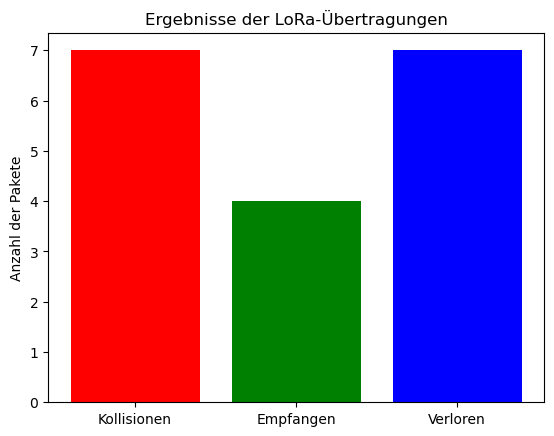

In [3]:
import simpy
import random
import numpy as np
import math
import matplotlib.pyplot as plt

# Globale Parameter
anzahlWassersensoren = 10       # Anzahl der Wassersensoren
simulationszeit = 60000        # Simulationsdauer (ms)
DETEKTIONSWAHRSCHEINLICHKEIT = 0.1  # Wahrscheinlichkeit, ein Leck zu erkennen (10 %)
grafiken = True                # Aktiviert die grafische Darstellung

# LoRa-Parameter
SF = 7                         # Spreading Factor
BW = 250                       # Bandbreite in kHz
TX_LEISTUNG = 5                # Sendeleistung in dBm
FREQUENZEN = [868100000, 868300000, 868500000]  # Verfügbare Frequenzen in Hz

# Ergebnisse
anzahlKollisionen = 0
anzahlEmpfangen = 0
anzahlVerloren = 0

# Listen für die Wassersensoren und Pakete
wassersensoren = []
paketeBeiBS = []

# Basisstation
bsx = 0
bsy = 0

class Wassersensor:
    def __init__(self, sensorid, bs, paketlaenge):
        self.sensorid = sensorid
        self.bs = bs
        self.paket = Packet(self.sensorid, paketlaenge, random.randint(100, 200))  # Zufällige Entfernung zwischen 100 und 200 Metern
        self.gesendet = 0

class Packet:
    def __init__(self, sensorid, laenge, entfernung):
        self.sensorid = sensorid
        self.laenge = laenge
        self.sf = SF
        self.bw = BW
        self.txpower = TX_LEISTUNG
        self.entfernung = entfernung
        self.freq = random.choice(FREQUENZEN)  # Zufällige Frequenz aus der Liste
        self.zeitInDerLuft = airtime(self.sf, 1, self.laenge, self.bw)
        self.kollidiert = 0
        self.verarbeitet = 0
        self.verloren = False

# Berechnung der Airtime
def airtime(sf, cr, laenge, bw):
    H = 1        # Impliziter Header aktiviert
    DE = 0       # Low Data Rate Optimization
    Npream = 8   # Anzahl der Präambel-Symbole
    if bw == 125 and sf in [11, 12]:
        DE = 1
    Tsym = (2**sf) / (bw * 1000)
    Tpream = (Npream + 4.25) * Tsym
    payloadSymbNB = 8 + max(math.ceil((8.0 * laenge - 4.0 * sf + 28 + 16 - 20 * H) / (4.0 * (sf - 2 * DE))) * (cr + 4), 0)
    Tpayload = payloadSymbNB * Tsym
    return Tpream + Tpayload

# Funktion zur Simulation der Übertragungen
def uebertragen(env, sensor):
    global anzahlKollisionen, anzahlEmpfangen, anzahlVerloren
    while True:
        # Wartezeit für die Leckerkennung simulieren
        yield env.timeout(1000)  # Überprüfung alle 1 Sekunde

        # Zufällige Erkennung eines Lecks
        if random.random() < DETEKTIONSWAHRSCHEINLICHKEIT:
            # Zufälliges Warten vor der Übertragung
            delay = random.randint(50, 500)  # Délai aléatoire entre 50 ms et 500 ms
            yield env.timeout(delay)
            print(f"Wassersensor {sensor.sensorid}: Leck erkannt, Übertragung auf Frequenz {sensor.paket.freq} Hz nach {delay} ms.")

            sensor.gesendet += 1
            if kollisionPruefen(sensor.paket):
                anzahlKollisionen += 1
                sensor.paket.kollidiert = 1

                # Backoff bei Kollision
                backoff = random.randint(500, 1500)  # Attente aléatoire pour retransmission
                print(f"Kollision für Wassersensor {sensor.sensorid}. Wartezeit von {backoff} ms.")
                yield env.timeout(backoff)
            else:
                anzahlEmpfangen += 1
                sensor.paket.kollidiert = 0

            yield env.timeout(sensor.paket.zeitInDerLuft)  # Zeit für die Übertragung
            if sensor.paket.kollidiert:
                anzahlVerloren += 1
        else:
            # Kein Leck erkannt -> Sleep-Modus
            print(f"Wassersensor {sensor.sensorid}: Kein Leck erkannt, Sleep-Modus.")
            yield env.timeout(3000)  # Sleep-Modus für 3 Sekunden

# Überprüfung von Kollisionen (berücksichtigt die Frequenz)
def kollisionPruefen(packet):
    global paketeBeiBS
    kollision = False
    for anderes in paketeBeiBS:
        if anderes.sf == packet.sf and anderes.freq == packet.freq and abs(anderes.entfernung - packet.entfernung) <= 30:
            kollision = True
            break
    paketeBeiBS.append(packet)
    return kollision

# Simulation und grafische Darstellung
def simulationStarten():
    global paketeBeiBS, env
    env = simpy.Environment()
    for i in range(anzahlWassersensoren):
        sensor = Wassersensor(i, 0, 8)  # Payload von 8 Bytes
        wassersensoren.append(sensor)
        env.process(uebertragen(env, sensor))
    env.run(until=simulationszeit)

    # Endergebnisse
    print("Kollisionen: ", anzahlKollisionen)
    print("Empfangene Pakete: ", anzahlEmpfangen)
    print("Verlorene Pakete: ", anzahlVerloren)

    # Grafische Darstellung
    if grafiken:
        plt.figure()
        plt.bar(["Kollisionen", "Empfangen", "Verloren"], [anzahlKollisionen, anzahlEmpfangen, anzahlVerloren], color=["red", "green", "blue"])
        plt.title("Ergebnisse der LoRa-Übertragungen")
        plt.ylabel("Anzahl der Pakete")
        plt.show()

# Simulation starten
simulationStarten()


Wassersensor 0: Kein Leck erkannt, Sleep-Modus.
Wassersensor 1: Kein Leck erkannt, Sleep-Modus.
Wassersensor 2: Kein Leck erkannt, Sleep-Modus.
Wassersensor 3: Kein Leck erkannt, Sleep-Modus.
Wassersensor 4: Kein Leck erkannt, Sleep-Modus.
Wassersensor 5: Kein Leck erkannt, Sleep-Modus.
Wassersensor 6: Kein Leck erkannt, Sleep-Modus.
Wassersensor 7: Kein Leck erkannt, Sleep-Modus.
Wassersensor 8: Kein Leck erkannt, Sleep-Modus.
Wassersensor 9: Kein Leck erkannt, Sleep-Modus.
Wassersensor 0: Kein Leck erkannt, Sleep-Modus.
Wassersensor 1: Kein Leck erkannt, Sleep-Modus.
Wassersensor 2: Kein Leck erkannt, Sleep-Modus.
Wassersensor 3: Kein Leck erkannt, Sleep-Modus.
Wassersensor 4: Kein Leck erkannt, Sleep-Modus.
Wassersensor 5: Kein Leck erkannt, Sleep-Modus.
Wassersensor 6: Kein Leck erkannt, Sleep-Modus.
Wassersensor 8: Kein Leck erkannt, Sleep-Modus.
Wassersensor 9: Kein Leck erkannt, Sleep-Modus.
Wassersensor 7: Leck erkannt, Übertragung nach 2100 ms.
Wassersensor 7: Kein Leck erkann

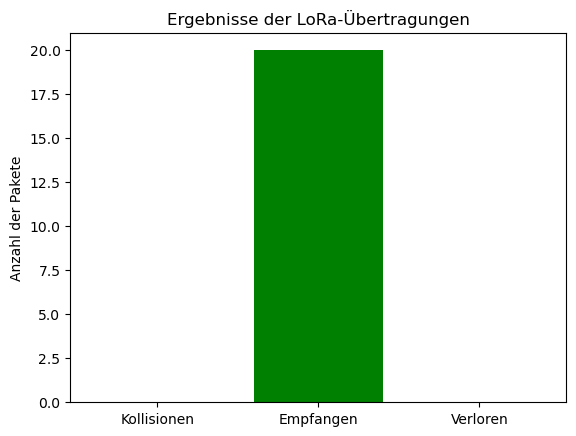

In [71]:
import simpy
import random
import math
import matplotlib.pyplot as plt

# Globale Parameter
anzahlWassersensoren = 10       # Anzahl der Wassersensoren
simulationszeit = 60000        # Simulationsdauer (ms)
DETEKTIONSWAHRSCHEINLICHKEIT = 0.1  # Wahrscheinlichkeit, ein Leck zu erkennen (10 %)
grafiken = True                # Aktiviert die grafische Darstellung
intervalle_fixe = 300          # Zeitdifferenz zwischen den Sensoren (in ms)

# LoRa-Parameter
SF = 7                         # Spreading Factor
BW = 250                       # Bandbreite in kHz
TX_LEISTUNG = 5                # Sendeleistung in dBm

# Ergebnisse
anzahlKollisionen = 0
anzahlEmpfangen = 0
anzahlVerloren = 0

# Listen für die Wassersensoren und Pakete
wassersensoren = []
paketeBeiBS = []

# Basisstation
bsx = 0
bsy = 0

class Wassersensor:
    def __init__(self, sensorid, bs, paketlaenge):
        self.sensorid = sensorid
        self.bs = bs
        self.paket = Packet(self.sensorid, paketlaenge, random.randint(100, 200))  # Zufällige Entfernung zwischen 100 und 200 Metern
        self.gesendet = 0

class Packet:
    def __init__(self, sensorid, laenge, entfernung):
        self.sensorid = sensorid
        self.laenge = laenge
        self.sf = SF
        self.bw = BW
        self.txpower = TX_LEISTUNG
        self.entfernung = entfernung
        self.zeitInDerLuft = airtime(self.sf, 1, self.laenge, self.bw)
        self.kollidiert = 0
        self.verarbeitet = 0
        self.verloren = False

# Berechnung der Airtime
def airtime(sf, cr, laenge, bw):
    H = 1        # Impliziter Header deaktiviert
    DE = 0       # Low Data Rate Optimization
    Npream = 8   # Anzahl der Präambel-Symbole
    if bw == 125 and sf in [11, 12]:
        DE = 1
    Tsym = (2**sf) / (bw * 1000)
    Tpream = (Npream + 4.25) * Tsym
    payloadSymbNB = 8 + max(math.ceil((8.0 * laenge - 4.0 * sf + 28 + 16 - 20 * H) / (4.0 * (sf - 2 * DE))) * (cr + 4), 0)
    Tpayload = payloadSymbNB * Tsym
    return Tpream + Tpayload

# Funktion zur Simulation der Übertragungen
def uebertragen(env, sensor):
    global anzahlKollisionen, anzahlEmpfangen, anzahlVerloren
    while True:
        # Wartezeit für die Leckerkennung simulieren
        yield env.timeout(1000)  # Überprüfung alle 1 Sekunde

        # Zufällige Erkennung eines Lecks
        if random.random() < DETEKTIONSWAHRSCHEINLICHKEIT:
            # Planification déterministe en fonction de l'identifiant du capteur
            fixed_time = sensor.sensorid * intervalle_fixe  # Décalage fixe
            yield env.timeout(fixed_time)
            print(f"Wassersensor {sensor.sensorid}: Leck erkannt, Übertragung nach {fixed_time} ms.")

            # Transmission des données
            sensor.gesendet += 1
            if kollisionPruefen(sensor.paket):
                anzahlKollisionen += 1
                sensor.paket.kollidiert = 1
                anzahlVerloren += 1
            else:
                anzahlEmpfangen += 1
                sensor.paket.kollidiert = 0

            # Temps de transmission du paquet
            yield env.timeout(sensor.paket.zeitInDerLuft)
            if sensor.paket in paketeBeiBS:
                paketeBeiBS.remove(sensor.paket)  # Supprimez le paquet après transmission
        else:
            # Mode veille si aucune fuite détectée
            print(f"Wassersensor {sensor.sensorid}: Kein Leck erkannt, Sleep-Modus.")
            yield env.timeout(3000)  # Mode veille pendant 3 Sekunden

# Überprüfung von Kollisionen (berücksichtigt die Frequenz)
def kollisionPruefen(packet):
    global paketeBeiBS
    kollision = False
    for anderes in paketeBeiBS:
        # Vérifiez si les paquets utilisent la même fréquence et si leurs temps se chevauchent
        if (anderes.sf == packet.sf and 
            abs(anderes.entfernung - packet.entfernung) <= 30):
            kollision = True
            break
    paketeBeiBS.append(packet)
    return kollision

# Simulation und grafische Darstellung
def simulationStarten():
    global paketeBeiBS, env
    env = simpy.Environment()
    for i in range(anzahlWassersensoren):
        sensor = Wassersensor(i, 0, 8)  # Payload von 8 Bytes
        wassersensoren.append(sensor)
        env.process(uebertragen(env, sensor))
    env.run(until=simulationszeit)

    # Endergebnisse
    print("Kollisionen: ", anzahlKollisionen)
    print("Empfangene Pakete: ", anzahlEmpfangen)
    print("Verlorene Pakete: ", anzahlVerloren)

    # Grafische Darstellung
    if grafiken:
        plt.figure()
        plt.bar(["Kollisionen", "Empfangen", "Verloren"], [anzahlKollisionen, anzahlEmpfangen, anzahlVerloren], color=["red", "green", "blue"])
        plt.title("Ergebnisse der LoRa-Übertragungen")
        plt.ylabel("Anzahl der Pakete")
        plt.show()

# Simulation starten
simulationStarten()
